In [30]:
!pip install torch torchvision torchaudio transformers sentencepiece spacy tqdm
!pip install torch_geometric -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 2.4 MB/s eta 0:00:06
     -- ------------------------------------- 0.8/12.8 MB 3.0 MB/s eta 0:00:04
     --- ------------------------------------ 1.0/12.8 MB 2.2 MB/s eta 0:00:06
     ---- ----------------------------------- 1.6/12.8 MB 1.9 MB/s eta 0:00:07
     ----- ---------------------------------- 1.8/12.8 MB 1.7 MB/s eta 0:00:07
     ------- -------------------------------- 2.4/12.8 MB 1.9 MB/s eta 0:00:06
     ------- -------------------------------- 2.4/12.8 MB 1.9 MB/s eta 0:00:06
     -------- ------------------------------- 2.6/12.8 MB 1.6 MB/s eta 0:00:0

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from torch_geometric.nn import GATConv
from transformers import MarianMTModel, MarianTokenizer


## Using pre trained transformer

In [45]:
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = MarianTokenizer.from_pretrained(model_name)
base_model = MarianMTModel.from_pretrained(model_name)
base_model.eval()


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

## Creating the dependency graphs

In [71]:
nlp = spacy.load("en_core_web_sm")

def get_dependency_graph(sentence):
    doc = nlp(sentence)
    edges = []
    for token in doc:
        for child in token.children:
            edges.append((token.i, child.i))

    G = nx.DiGraph(edges)
    labels = {i: token.text for i, token in enumerate(doc)}
    pos_tags = {i: token.pos_ for i, token in enumerate(doc)}

    plt.figure(figsize=(8,5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, labels=labels, node_color="skyblue", node_size=1500, font_size=10, arrows=True)
    plt.title("Dependency Graph")
    plt.show()

    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    x = torch.randn(len(doc), 256)  # Random embeddings for now
    return x, edge_index, [token.text for token in doc]


## Defining Graph encdoder

In [70]:
class GraphAugmentedEncoder(nn.Module):
    def __init__(self, transformer, gat_hidden=256, heads=4):
        super().__init__()
        self.transformer = transformer
        self.gat1 = GATConv(gat_hidden, gat_hidden, heads=heads, concat=False)
        self.gat2 = GATConv(gat_hidden, gat_hidden, heads=heads, concat=False)
        self.proj = nn.Linear(gat_hidden, transformer.config.d_model)

    def forward(self, input_ids, attention_mask, x, edge_index):
        outputs = self.transformer.model.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        enc_hidden = outputs.last_hidden_state # Shape: (batch_size, sequence_length, hidden_size)

        # Graph embedding
        graph_embed = F.relu(self.gat1(x, edge_index)) # Shape: (num_nodes, gat_hidden)
        graph_embed = F.relu(self.gat2(graph_embed, edge_index)) # Shape: (num_nodes, gat_hidden)
        graph_embed = self.proj(graph_embed) # Shape: (num_nodes, transformer_hidden_size)

        # Align graph embedding sequence length with encoder hidden state sequence length
        enc_seq_len = enc_hidden.shape[1]
        graph_num_nodes = graph_embed.shape[0]

        graph_embed_aligned = graph_embed
        if graph_num_nodes < enc_seq_len:
            # Pad graph embedding if it's shorter
            padding_size = enc_seq_len - graph_num_nodes
            # Pad along the sequence dimension (dimension 0)
            graph_embed_aligned = F.pad(graph_embed, (0, 0, 0, padding_size))
        elif graph_num_nodes > enc_seq_len:
             # Truncate graph embedding if it's longer
            graph_embed_aligned = graph_embed[:enc_seq_len, :]

        # Combine embeddings (assuming batch size is 1 for now as in the translation function)
        # Unsqueeze graph_embed_aligned to match batch dimension of enc_hidden
        combined = enc_hidden + graph_embed_aligned.unsqueeze(0)

        return combined.float() # Explicitly return float tensor

In [72]:
graph_encoder = GraphAugmentedEncoder(base_model)

## Enode the transformer with dependenccy graphs

In [73]:
from transformers.modeling_outputs import BaseModelOutput # Import BaseModelOutput

def translate_with_graph(sentence):
    # Graph extraction
    x, edge_index, tokens = get_dependency_graph(sentence)

    # Add checks for empty or invalid graph data
    if not tokens or x.size(0) == 0 or edge_index.size(1) == 0:
        print(f"Skipping graph augmentation for sentence due to invalid graph data: {sentence}")
        # Fallback to base model translation
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
             outputs = base_model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=60
            )
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return translation


    # Tokenize
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

    try:
        # Encode with graph
        with torch.no_grad():
            combined_enc = graph_encoder(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                x=x,
                edge_index=edge_index
            )

            # Wrap combined_enc in BaseModelOutput
            encoder_outputs_for_generation = BaseModelOutput(last_hidden_state=combined_enc)

            outputs = base_model.generate(
                encoder_outputs=encoder_outputs_for_generation, # Pass the wrapped object
                attention_mask=inputs["attention_mask"],
                max_length=60
            )

        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return translation

    except RuntimeError as e:
        print(f"RuntimeError during graph-augmented encoding for sentence: {sentence}. Error: {e}")
        print("Falling back to base model translation.")
        # Fallback to base model translation if graph-augmented encoding fails
        inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
             outputs = base_model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=60
            )
        translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
        return translation

#Visualize some outputs

EN: The car is red and fast.


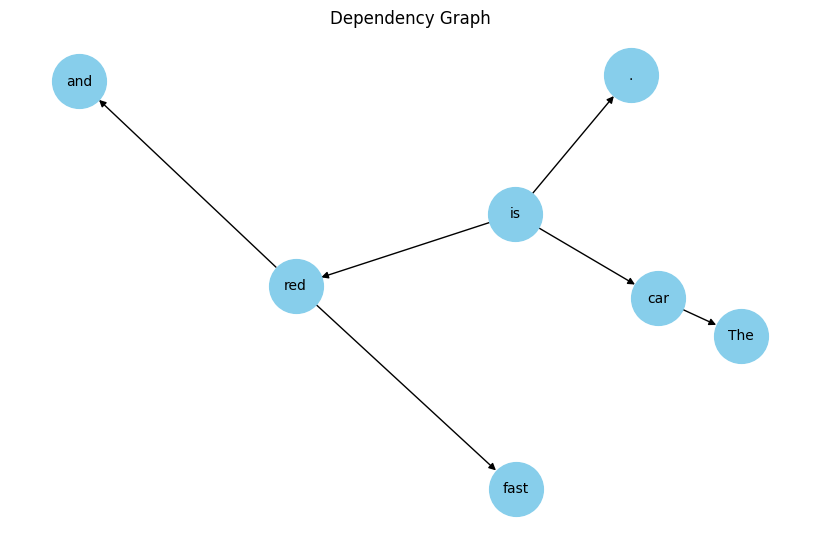

FR: La voiture est rouge et rapide.

EN: Where is the nearest library?


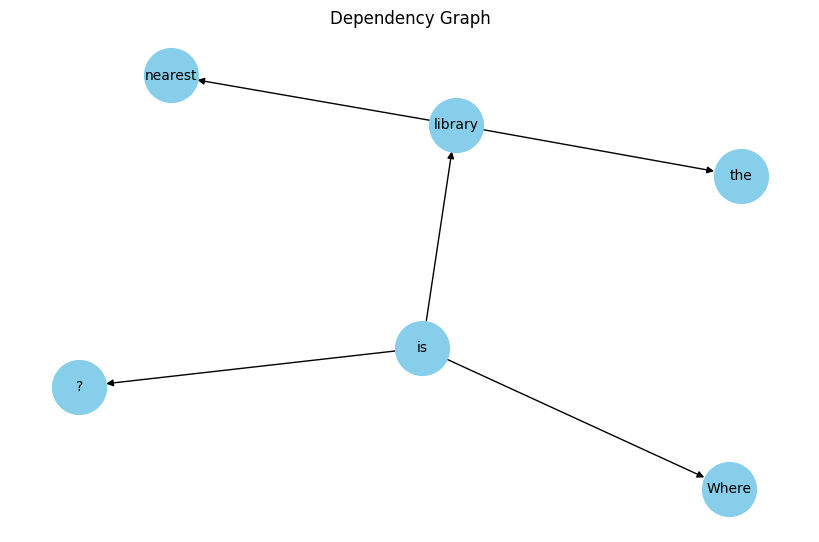

FR: Où est la bibliothèque la plus proche ?

EN: I love learning artificial intelligence.


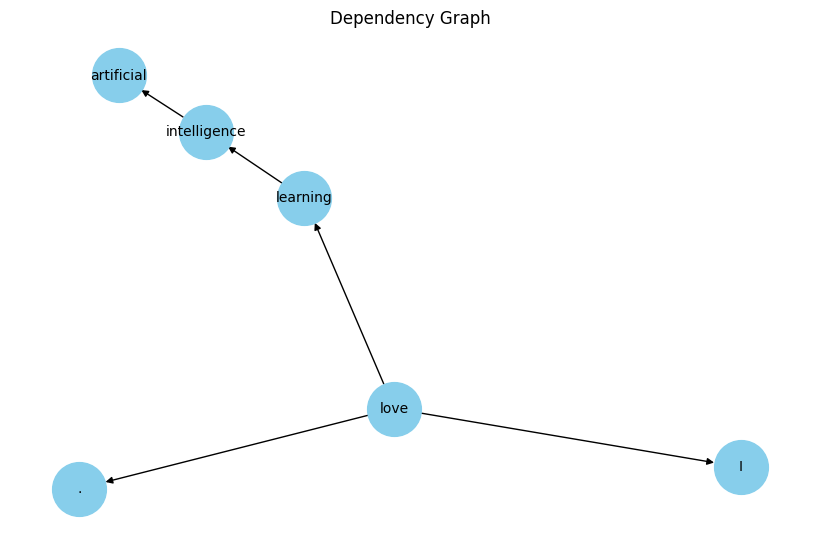

FR: J'adore apprendre l'intelligence artificielle.

EN: The little boy plays with his dog in the park.


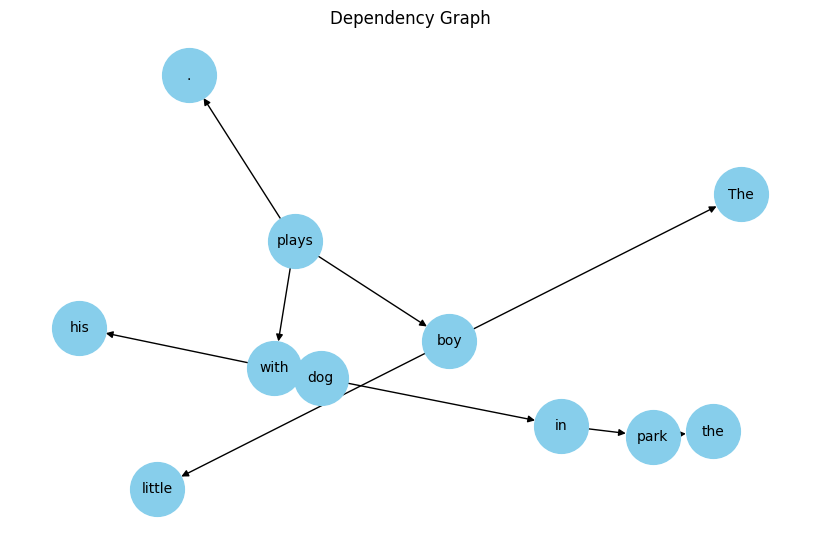

FR: Le petit garçon joue avec son chien dans le parc.



In [74]:
examples = [
    "The car is red and fast.",
    "Where is the nearest library?",
    "I love learning artificial intelligence.",
    "The little boy plays with his dog in the park."
]

for s in examples:
    print(f"EN: {s}")
    print(f"FR: {translate_with_graph(s)}\n")
